# Project Stage 02

# COMP5310: Binary Classification Model to Predict Term Deposit Campaign Subscription

## Bank Marketing Data Set
The data is related with direct marketing campaigns of a European Bank. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

# Stage 02: Model Implementation

## Step 1: Importing Libraries

The libraries needed for implementation and analysis are imported this includes:
imblearn
, itertools
, matplot
, numpy
, pandas
, random
, scipy
and sklearn

In [1]:
import numpy as np
import pandas as pd
import random
import psycopg2
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, SelectFdr, SelectFpr, mutual_info_classif, f_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, average_precision_score, classification_report, confusion_matrix, f1_score, matthews_corrcoef, roc_curve, precision_recall_curve, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.metrics import classification_report_imbalanced
from scipy import interp
from scipy.stats.mstats import kruskalwallis
from scipy.stats import wilcoxon
from itertools import cycle
from matplotlib import font_manager 

C:\Users\EmilLaurence\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Step 2: Define Amazon Web Services (AWS) connections
This is used for retrieving data from Postgres SQL database hosted in AWS

In [4]:
try: 
    #conn = psycopg2.connect(database='EmilLaurence', host='127.0.0.1',user='postgres', password='')
    conn = psycopg2.connect(database='COMP5310', host='comp5310.cge7dneddtek.ap-southeast-2.rds.amazonaws.com',
                           user='epas6415', password='460466466')
    print('Test Connection Successful!')
except Exception as e:
    print("Unable to connect to the database")
    print(e)

Test Connection Successful!


In [5]:
#Query Function
def pgquery( conn, sqlcmd, args ):
   """ utility function to execute some SQL query statement
       can take optional arguments to fill in (dictionary)
       will print out on screen the result set of the query
       error and transaction handling built-in """
   retval = False
   query_result = []
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
                cur.execute(sqlcmd)
            else:
                cur.execute(sqlcmd, args)
            for record in cur:
                query_result.append(record)
            retval = True
         except Exception as e:
            print("DB Read Error: ")
            print(e)
   return query_result

#Execution Function
def pgexec( conn, sqlcmd, args, msg ):
   """ utility function to execute some SQL statement
       can take optional arguments to fill in (dictionary)
       error and transaction handling built-in """
   retval = False
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
               cur.execute(sqlcmd)
            else:
               cur.execute(sqlcmd, args)
            if msg is not None:
                print("Success: " + msg)
            retval = True
         except Exception as e:
            print("DB Error: ")
            print(e)
   return retval

## Step 3: Preparing the Data Set

From the FACT_BANK_TRAINING and FACT_BANK_TEST table, the data is prepared to ensure correct compatibility of the data after data cleansing has been performed in Stage 01.

In [6]:
# Select Data from the Training Table
query_stmt ="""
SELECT 
 Age
,CASE WHEN Job = 'Student' THEN 1 ELSE 0 END AS Student
,CASE WHEN Job = 'Retired' THEN 1 ELSE 0 END AS Retired
,CASE WHEN Job = 'Blue Collar' THEN 1 ELSE 0 END AS Blue_Collar
,CASE WHEN Job = 'Entrepreneur' THEN 1 ELSE 0 END AS Entrepreneur
,CASE WHEN Job = 'Self-Employed' THEN 1 ELSE 0 END AS Self_Employed
,CASE WHEN Job = 'Administration' THEN 1 ELSE 0 END AS Administration
,CASE WHEN Job = 'Services' THEN 1 ELSE 0 END AS Services
,CASE WHEN Job = 'Housemaid' THEN 1 ELSE 0 END AS Housemaid
,CASE WHEN Job = 'Management' THEN 1 ELSE 0 END AS Management
,CASE WHEN Job = 'Technician' THEN 1 ELSE 0 END AS Technician
,CASE WHEN Job = 'Unemployed' THEN 1 ELSE 0 END AS Unemployed
,CASE WHEN Marital_Status = 'Single' THEN 1 ELSE 0 END AS Single
,CASE WHEN Marital_Status = 'Married' THEN 1 ELSE 0 END AS Married
,CASE WHEN Marital_Status = 'Divorced' THEN 1 ELSE 0 END AS Divorced
,CASE WHEN Educational_Attainment = 'Primary First Stage' THEN 1 ELSE 0 END AS Primary_First_Stage
,CASE WHEN Educational_Attainment = 'Primary Second Stage' THEN 1 ELSE 0 END AS Primary_Second_Stage
,CASE WHEN Educational_Attainment = 'Middle School' THEN 1 ELSE 0 END AS Middle_School
,CASE WHEN Educational_Attainment = 'High School' THEN 1 ELSE 0 END AS High_School
,CASE WHEN Educational_Attainment = 'University Degree' THEN 1 ELSE 0 END AS University_Degree
,CASE WHEN Educational_Attainment = 'Illiterate' THEN 1 ELSE 0 END AS Illiterate
,CASE WHEN Educational_Attainment = 'Professional Course' THEN 1 ELSE 0 END AS Professional_Course
,CASE WHEN Credit_Default_Flag = 'Yes' THEN 1 ELSE 0 END AS Credit_Default_Flag
,CASE WHEN Housing_Loan_Flag = 'Yes' THEN 1 ELSE 0 END AS Housing_Loan_Flag
,CASE WHEN Personal_Loan_Flag = 'Yes' THEN 1 ELSE 0 END AS Personal_Loan_Flag
,CASE WHEN Contact_Channel_Type = 'Cellular' THEN 1 ELSE 0 END AS Cellular_Contact
,CASE WHEN Contact_Channel_Type = 'Telephone' THEN 1 ELSE 0 END AS Telephone_Contact
,CASE WHEN Contact_Month = 'January' THEN 1 ELSE 0 END AS January
,CASE WHEN Contact_Month = 'February' THEN 1 ELSE 0 END AS February
,CASE WHEN Contact_Month = 'March' THEN 1 ELSE 0 END AS March
,CASE WHEN Contact_Month = 'April' THEN 1 ELSE 0 END AS April
,CASE WHEN Contact_Month = 'May' THEN 1 ELSE 0 END AS May
,CASE WHEN Contact_Month = 'June' THEN 1 ELSE 0 END AS June
,CASE WHEN Contact_Month = 'July' THEN 1 ELSE 0 END AS July
,CASE WHEN Contact_Month = 'August' THEN 1 ELSE 0 END AS August
,CASE WHEN Contact_Month = 'September' THEN 1 ELSE 0 END AS September
,CASE WHEN Contact_Month = 'October' THEN 1 ELSE 0 END AS October
,CASE WHEN Contact_Month = 'November' THEN 1 ELSE 0 END AS November
,CASE WHEN Contact_Month = 'December' THEN 1 ELSE 0 END AS December
,CASE WHEN Contact_Day_of_Week = 'Monday' THEN 1 ELSE 0 END AS Monday
,CASE WHEN Contact_Day_of_Week = 'Tuesday' THEN 1 ELSE 0 END AS Tuesday
,CASE WHEN Contact_Day_of_Week = 'Wednesday' THEN 1 ELSE 0 END AS Wednesday
,CASE WHEN Contact_Day_of_Week = 'Thursday' THEN 1 ELSE 0 END AS Thursday
,CASE WHEN Contact_Day_of_Week = 'Friday' THEN 1 ELSE 0 END AS Friday
,Last_Contact_Duration
,Campaign_Contacts
,CASE WHEN Previous_Campaign_Last_Contact = 0 THEN 0 ELSE 1 END AS Previous_Campaign_Last_Contact_Flag
,Previous_Campaign_Last_Contact
,Previous_Campaign_Contact
,CASE WHEN Previous_Campaign_Outcome = 'Success' THEN 1 ELSE 0 END AS Previous_Campaign_Outcome
--,CASE WHEN Previous_Campaign_Outcome = 'Failure' THEN 1 ELSE 0 END AS Previous_Campaign_Failure
,CASE WHEN Current_Outcome = 'Yes' THEN 0 ELSE 1 END AS Campaign_Outcome 
FROM public.fact_bank_training;
"""

# Execute Query Statement
train = pgquery (conn, query_stmt, None)

# Convert into Matrix Form
traindata = pd.DataFrame(train).as_matrix()

In [7]:
# Select Data from the Test Table
query_stmt ="""
SELECT 
 Age
,CASE WHEN Job = 'Student' THEN 1 ELSE 0 END AS Student
,CASE WHEN Job = 'Retired' THEN 1 ELSE 0 END AS Retired
,CASE WHEN Job = 'Blue Collar' THEN 1 ELSE 0 END AS Blue_Collar
,CASE WHEN Job = 'Entrepreneur' THEN 1 ELSE 0 END AS Entrepreneur
,CASE WHEN Job = 'Self-Employed' THEN 1 ELSE 0 END AS Self_Employed
,CASE WHEN Job = 'Administration' THEN 1 ELSE 0 END AS Administration
,CASE WHEN Job = 'Services' THEN 1 ELSE 0 END AS Services
,CASE WHEN Job = 'Housemaid' THEN 1 ELSE 0 END AS Housemaid
,CASE WHEN Job = 'Management' THEN 1 ELSE 0 END AS Management
,CASE WHEN Job = 'Technician' THEN 1 ELSE 0 END AS Technician
,CASE WHEN Job = 'Unemployed' THEN 1 ELSE 0 END AS Unemployed
,CASE WHEN Marital_Status = 'Single' THEN 1 ELSE 0 END AS Single
,CASE WHEN Marital_Status = 'Married' THEN 1 ELSE 0 END AS Married
,CASE WHEN Marital_Status = 'Divorced' THEN 1 ELSE 0 END AS Divorced
,CASE WHEN Educational_Attainment = 'Primary First Stage' THEN 1 ELSE 0 END AS Primary_First_Stage
,CASE WHEN Educational_Attainment = 'Primary Second Stage' THEN 1 ELSE 0 END AS Primary_Second_Stage
,CASE WHEN Educational_Attainment = 'Middle School' THEN 1 ELSE 0 END AS Middle_School
,CASE WHEN Educational_Attainment = 'High School' THEN 1 ELSE 0 END AS High_School
,CASE WHEN Educational_Attainment = 'University Degree' THEN 1 ELSE 0 END AS University_Degree
,CASE WHEN Educational_Attainment = 'Illiterate' THEN 1 ELSE 0 END AS Illiterate
,CASE WHEN Educational_Attainment = 'Professional Course' THEN 1 ELSE 0 END AS Professional_Course
,CASE WHEN Credit_Default_Flag = 'Yes' THEN 1 ELSE 0 END AS Credit_Default_Flag
,CASE WHEN Housing_Loan_Flag = 'Yes' THEN 1 ELSE 0 END AS Housing_Loan_Flag
,CASE WHEN Personal_Loan_Flag = 'Yes' THEN 1 ELSE 0 END AS Personal_Loan_Flag
,CASE WHEN Contact_Channel_Type = 'Cellular' THEN 1 ELSE 0 END AS Cellular_Contact
,CASE WHEN Contact_Channel_Type = 'Telephone' THEN 1 ELSE 0 END AS Telephone_Contact
,CASE WHEN Contact_Month = 'January' THEN 1 ELSE 0 END AS January
,CASE WHEN Contact_Month = 'February' THEN 1 ELSE 0 END AS February
,CASE WHEN Contact_Month = 'March' THEN 1 ELSE 0 END AS March
,CASE WHEN Contact_Month = 'April' THEN 1 ELSE 0 END AS April
,CASE WHEN Contact_Month = 'May' THEN 1 ELSE 0 END AS May
,CASE WHEN Contact_Month = 'June' THEN 1 ELSE 0 END AS June
,CASE WHEN Contact_Month = 'July' THEN 1 ELSE 0 END AS July
,CASE WHEN Contact_Month = 'August' THEN 1 ELSE 0 END AS August
,CASE WHEN Contact_Month = 'September' THEN 1 ELSE 0 END AS September
,CASE WHEN Contact_Month = 'October' THEN 1 ELSE 0 END AS October
,CASE WHEN Contact_Month = 'November' THEN 1 ELSE 0 END AS November
,CASE WHEN Contact_Month = 'December' THEN 1 ELSE 0 END AS December
,CASE WHEN Contact_Day_of_Week = 'Monday' THEN 1 ELSE 0 END AS Monday
,CASE WHEN Contact_Day_of_Week = 'Tuesday' THEN 1 ELSE 0 END AS Tuesday
,CASE WHEN Contact_Day_of_Week = 'Wednesday' THEN 1 ELSE 0 END AS Wednesday
,CASE WHEN Contact_Day_of_Week = 'Thursday' THEN 1 ELSE 0 END AS Thursday
,CASE WHEN Contact_Day_of_Week = 'Friday' THEN 1 ELSE 0 END AS Friday
,Last_Contact_Duration
,Campaign_Contacts
,CASE WHEN Previous_Campaign_Last_Contact = 0 THEN 0 ELSE 1 END AS Previous_Campaign_Last_Contact_Flag
,Previous_Campaign_Last_Contact
,Previous_Campaign_Contact
,CASE WHEN Previous_Campaign_Outcome = 'Success' THEN 1 ELSE 0 END AS Previous_Campaign_Outcome
--,CASE WHEN Previous_Campaign_Outcome = 'Failure' THEN 1 ELSE 0 END AS Previous_Campaign_Failure
,CASE WHEN Current_Outcome = 'Yes' THEN 0 ELSE 1 END AS Campaign_Outcome 
FROM public.fact_bank_test;
"""

# Execute Query Statement
test = pgquery (conn, query_stmt, None)

# Convert into Matrix Form
testdata = pd.DataFrame(test).as_matrix()

## Step 4: List the possible predictors
This step prepares the list of columns to be scored during the SelectKBest process.

In [8]:
# List of all features that can be used for prediction
predictors = [
 'Age'
,'Student'
,'Retired'
,'Blue_Collar'
,'Entrepreneur'
,'Self_Employed'
,'Administration'
,'Services'
,'Housemaid'
,'Management'
,'Technician'
,'Unemployed'
,'Single'
,'Married'
,'Divorced'
,'Primary_First_Stage'
,'Primary_Second_Stage'
,'Middle_School'
,'High_School'
,'University_Degree'
,'Illiterate'
,'Professional_Course'
,'Credit_Default_Flag'
,'Housing_Loan_Flag'
,'Personal_Loan_Flag'
,'Cellular_Contact'
,'Telephone_Contact'
,'January'
,'February'
,'March'
,'April'
,'May'
,'June'
,'July'
,'August'
,'September'
,'October'
,'November'
,'December'
,'Monday'
,'Tuesday'
,'Wednesday'
,'Thursday'
,'Friday'
,'Last_Contact_Duration'
,'Campaign_Contacts'
,'Previous_Campaign_Last_Contact_Flag'
,'Previous_Campaign_Last_Contact'
,'Previous_Campaign_Contact'
,'Previous_Campaign_Outcome'
]

predictorList = {}

i = 0

for pred in predictors:
    predictorList[pred] = i
    i+=1

In [9]:
possiblePredictors = [
 'Age'
,'Student'
,'Retired'
,'Blue_Collar'
,'Entrepreneur'
,'Self_Employed'
,'Administration'
,'Services'
,'Housemaid'
,'Management'
,'Technician'
,'Unemployed'
,'Single'
,'Married'
,'Divorced'
,'Primary_First_Stage'
,'Primary_Second_Stage'
,'Middle_School'
,'High_School'
,'University_Degree'
,'Illiterate'
,'Professional_Course'
,'Credit_Default_Flag'
,'Housing_Loan_Flag'
,'Personal_Loan_Flag'
,'Cellular_Contact'
,'Telephone_Contact'
#,'January'
#,'February'
,'March'
,'April'
,'May'
,'June'
,'July'
,'August'
,'September'
,'October'
,'November'
,'December'
,'Monday'
,'Tuesday'
,'Wednesday'
,'Thursday'
,'Friday'
,'Last_Contact_Duration'
,'Campaign_Contacts'
,'Previous_Campaign_Last_Contact_Flag'
,'Previous_Campaign_Last_Contact'
,'Previous_Campaign_Contact'
,'Previous_Campaign_Outcome'
]

feature = [predictorList[x] for x in possiblePredictors]

## Step 5: Prepare the X and Y component of the training and test data set
This stage extract the input X and target Y variables for the training and test data

In [10]:
# Prepare Training and Test Data
X_train = traindata[:,feature]
Y_train = traindata[:,-1:].ravel()
X_test = testdata[:,feature]
Y_test = testdata[:,-1:].ravel()

# Initialise Target Labels
target_label = ['Yes', 'No']

## Step 6: Feature Scoring
This step performs feature scoring using `f_classif` between the input variables and output variables.

In [11]:
# Set Default Font to Times New Roman
font_manager.findfont('Times New Roman')
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 

# Perform feature selection
fs = SelectKBest(f_classif, k='all')
fs.fit(X_train, Y_train)

scores = fs.scores_

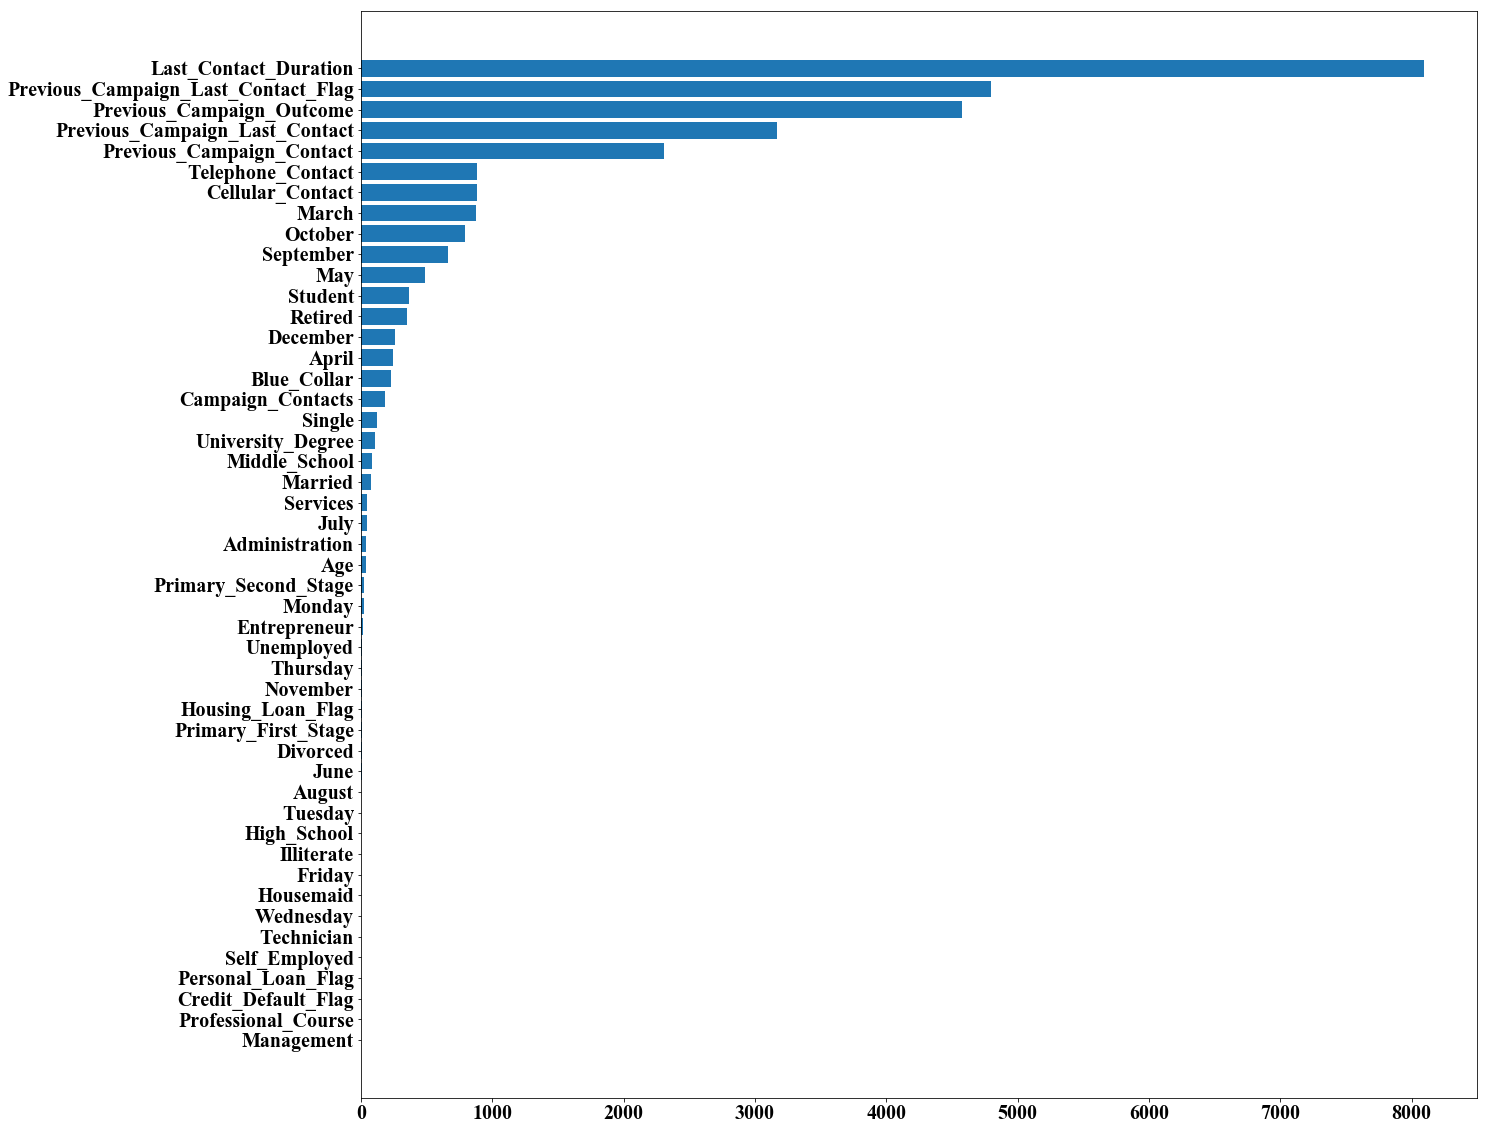

In [13]:
feature_score = {}

for d in range(len(possiblePredictors)):
    feature_score[possiblePredictors[d]] = scores[d]

sort_feature = sorted(feature_score, key=feature_score.get)
sort_score = [feature_score[s] for s in sort_feature]

# Plot the feature score
plt.figure(figsize=(20,20))
plt.barh(range(len(sort_feature)), sort_score)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.yticks(range(len(sort_feature)), sort_feature, rotation='horizontal')
plt.savefig('bargraph.png',bbox_inches='tight')
plt.show()

## Step 7: Subtractive Feature Analysis
Determining the impact of Top 5 features in the measures using MNB and LR algorithms

In [14]:
possiblePredictors = [
 'Age'
,'Student'
,'Retired'
,'Blue_Collar'
,'Entrepreneur'
,'Self_Employed'
,'Administration'
,'Services'
,'Housemaid'
,'Management'
,'Technician'
,'Unemployed'
,'Single'
,'Married'
,'Divorced'
,'Primary_First_Stage'
,'Primary_Second_Stage'
,'Middle_School'
,'High_School'
,'University_Degree'
,'Illiterate'
,'Professional_Course'
,'Credit_Default_Flag'
,'Housing_Loan_Flag'
,'Personal_Loan_Flag'
,'Cellular_Contact'
,'Telephone_Contact'
#,'January'
#,'February'
,'March'
,'April'
,'May'
,'June'
,'July'
,'August'
,'September'
,'October'
,'November'
,'December'
,'Monday'
,'Tuesday'
,'Wednesday'
,'Thursday'
,'Friday'
#,'Last_Contact_Duration'
,'Campaign_Contacts'
#,'Previous_Campaign_Last_Contact_Flag'
#,'Previous_Campaign_Last_Contact'
#,'Previous_Campaign_Contact'
#,'Previous_Campaign_Outcome'
]

subtractive_feature = [predictorList[x] for x in possiblePredictors]

# Prepare Training and Test Data for subtractive feature analysis
Xsub_train = traindata[:,subtractive_feature]
Y_train = traindata[:,-1:].ravel()
Xsub_test = testdata[:,subtractive_feature]
Y_test = testdata[:,-1:].ravel()

In [15]:
# Naive Bayes and Logistic Regression
mnb = MultinomialNB()
lr = LogisticRegression()

# Benchmark performance before substractive feature analysis
print('Before subtractive feature analysis\n')

mnb.fit(X_train, Y_train)
lr.fit(X_train, Y_train)

Ymnb_predict = mnb.predict(X_test)
Ylr_predict = lr.predict(X_test)

print('Multinomial Naive Bayes')
print('Accuracy:',accuracy_score(Y_test, Ymnb_predict))
print(classification_report_imbalanced(Y_test, Ymnb_predict))
print('MCC:',matthews_corrcoef(Y_test, Ymnb_predict))

print('\nLogistic Regression')
print('Accuracy:',accuracy_score(Y_test, Ylr_predict))
print(classification_report_imbalanced(Y_test, Ylr_predict))
print('MCC:',matthews_corrcoef(Y_test, Ylr_predict))

# Benchmark performance after substractive feature analysis
print('After subtractive feature analysis\n')

mnb.fit(Xsub_train, Y_train)
lr.fit(Xsub_train, Y_train)

Ymnb_predict = mnb.predict(Xsub_test)
Ylr_predict = lr.predict(Xsub_test)

print('\nMultinomial Naive Bayes')
print('Accuracy:',accuracy_score(Y_test, Ymnb_predict))
print(classification_report_imbalanced(Y_test, Ymnb_predict))
print('MCC:',matthews_corrcoef(Y_test, Ymnb_predict))

print('\nLogistic Regression')
print('Accuracy:',accuracy_score(Y_test, Ylr_predict))
print(classification_report_imbalanced(Y_test, Ylr_predict))
print('MCC:',matthews_corrcoef(Y_test, Ylr_predict))

Before subtractive feature analysis

Multinomial Naive Bayes
Accuracy: 0.813061422675
                   pre       rec       spe        f1       geo       iba       sup

          0       0.33      0.67      0.83      0.44      0.56      0.29       451
          1       0.95      0.83      0.67      0.89      0.56      0.33      3668

avg / total       0.88      0.81      0.69      0.84      0.56      0.33      4119

MCC: 0.373500587744

Logistic Regression
Accuracy: 0.910415149308
                   pre       rec       spe        f1       geo       iba       sup

          0       0.67      0.35      0.98      0.46      0.79      0.61       451
          1       0.93      0.98      0.35      0.95      0.79      0.64      3668

avg / total       0.90      0.91      0.42      0.90      0.79      0.63      4119

MCC: 0.446314836508
After subtractive feature analysis


Multinomial Naive Bayes
Accuracy: 0.889293517844
                   pre       rec       spe        f1       geo       iba

## Step 8: Top 25 SelectKBest Features
This step performs feature scoring using `mutual_info_classif` between the input variables and output variables.

In [17]:
# Perform Top 25 feature selection
fs = SelectKBest(f_classif, k=25)
fs.fit(X_train, Y_train)

Xs_train = fs.transform(X_train)
Xs_test = fs.transform(X_test)

## Step 9: Handling Imbalanced Data
Using Random Over-sampling, Random Under-sampling, Edited Nearest Neighbour and Synthetic Minority Over Sampling Technique

In [24]:
# Model Selection
mnb = MultinomialNB()
lr = LogisticRegression()

mnb.fit(Xs_train, Y_train)
lr.fit(Xs_train, Y_train)

Ymnb_predict = mnb.predict(Xs_test)
Ylr_predict = lr.predict(Xs_test)

# Multinomial Naive Bayes
print('Multinomial Naive Bayes')
print(classification_report_imbalanced(Y_test, Ymnb_predict))
print('Matthews Correlation Coefficient:', matthews_corrcoef(Y_test, Ymnb_predict))

# Logistic Regression
print('\nLogistic Regression')
print(classification_report_imbalanced(Y_test, Ylr_predict))
print('Matthews Correlation Coefficient:',matthews_corrcoef(Y_test, Ylr_predict))

Multinomial Naive Bayes
                   pre       rec       spe        f1       geo       iba       sup

          0       0.32      0.67      0.83      0.44      0.56      0.29       451
          1       0.95      0.83      0.67      0.89      0.56      0.33      3668

avg / total       0.88      0.81      0.69      0.84      0.56      0.32      4119

Matthews Correlation Coefficient: 0.370725430983

Logistic Regression
                   pre       rec       spe        f1       geo       iba       sup

          0       0.66      0.35      0.98      0.46      0.78      0.60       451
          1       0.92      0.98      0.35      0.95      0.78      0.63      3668

avg / total       0.90      0.91      0.42      0.90      0.78      0.63      4119

Matthews Correlation Coefficient: 0.442611632435


In [24]:
# Using Random Over-sampling
ros = RandomOverSampler(ratio = 0.5)
Xros_train, Yros_train = ros.fit_sample(Xs_train, Y_train)

mnb.fit(Xros_train, Yros_train)
lr.fit(Xros_train, Yros_train)

Ymnb_predict = mnb.predict(Xs_test)
Ylr_predict = lr.predict(Xs_test)

# Multinomial Naive Bayes
print('Multinomial Naive Bayes')
print(classification_report_imbalanced(Y_test, Ymnb_predict))
print('Matthews Correlation Coefficient:',matthews_corrcoef(Y_test, Ymnb_predict))

# Logistic Regression
print('\nLogistic Regression')
print(classification_report_imbalanced(Y_test, Ylr_predict))
print('Matthews Correlation Coefficient:',matthews_corrcoef(Y_test, Ylr_predict))

Multinomial Naive Bayes
                   pre       rec       spe        f1       geo       iba       sup

          0       0.32      0.69      0.82      0.43      0.55      0.28       451
          1       0.96      0.82      0.69      0.88      0.55      0.32      3668

avg / total       0.89      0.80      0.70      0.83      0.55      0.32      4119

Matthews Correlation Coefficient: 0.370437625212

Logistic Regression
                   pre       rec       spe        f1       geo       iba       sup

          0       0.49      0.70      0.91      0.58      0.69      0.45       451
          1       0.96      0.91      0.70      0.94      0.69      0.50      3668

avg / total       0.91      0.89      0.72      0.90      0.69      0.49      4119

Matthews Correlation Coefficient: 0.526371547637


In [26]:
# Using Random Under-sampling
rus = RandomUnderSampler(ratio = 0.5)
Xrus_train, Yrus_train = rus.fit_sample(Xs_train, Y_train)

mnb.fit(Xrus_train, Yrus_train)
lr.fit(Xrus_train, Yrus_train)

Ymnb_predict = mnb.predict(Xs_test)
Ylr_predict = lr.predict(Xs_test)

# Multinomial Naive Bayes
print('Multinomial Naive Bayes')
print(classification_report_imbalanced(Y_test, Ymnb_predict))
print('Matthews Correlation Coefficient:',matthews_corrcoef(Y_test, Ymnb_predict))

# Logistic Regression
print('\nLogistic Regression')
print(classification_report_imbalanced(Y_test, Ylr_predict))
print('Matthews Correlation Coefficient:',matthews_corrcoef(Y_test, Ylr_predict))

Multinomial Naive Bayes
                   pre       rec       spe        f1       geo       iba       sup

          0       0.32      0.69      0.82      0.44      0.55      0.29       451
          1       0.96      0.82      0.69      0.88      0.55      0.32      3668

avg / total       0.89      0.80      0.70      0.83      0.55      0.32      4119

Matthews Correlation Coefficient: 0.373258506699

Logistic Regression
                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.68      0.92      0.58      0.69      0.46       451
          1       0.96      0.92      0.68      0.94      0.69      0.50      3668

avg / total       0.91      0.89      0.71      0.90      0.69      0.49      4119

Matthews Correlation Coefficient: 0.522668173884


In [51]:
# Using Edited Nearest Neighbor
enn = EditedNearestNeighbours(size_ngh=5, random_state=1)
Xenn_train, Yenn_train = enn.fit_sample(Xs_train, Y_train)

mnb.fit(Xenn_train, Yenn_train)
lr.fit(Xenn_train, Yenn_train)

Ymnb_predict = mnb.predict(Xs_test)
Ylr_predict = lr.predict(Xs_test)

# Multinomial Naive Bayes
print('Multinomial Naive Bayes')
print(classification_report_imbalanced(Y_test, Ymnb_predict))
print('Matthews Correlation Coefficient:',matthews_corrcoef(Y_test, Ymnb_predict))

# Logistic Regression
print('\nLogistic Regression')
print(classification_report_imbalanced(Y_test, Ylr_predict))
print('Matthews Correlation Coefficient:',matthews_corrcoef(Y_test, Ylr_predict))

Multinomial Naive Bayes
                   pre       rec       spe        f1       geo       iba       sup

          0       0.28      0.76      0.76      0.41      0.52      0.25       451
          1       0.96      0.76      0.76      0.85      0.52      0.29      3668

avg / total       0.89      0.76      0.76      0.80      0.52      0.28      4119

Matthews Correlation Coefficient: 0.355533721893

Logistic Regression
                   pre       rec       spe        f1       geo       iba       sup

          0       0.48      0.69      0.91      0.56      0.68      0.43       451
          1       0.96      0.91      0.69      0.93      0.68      0.48      3668

avg / total       0.91      0.88      0.71      0.89      0.68      0.47      4119

Matthews Correlation Coefficient: 0.509830633456


In [53]:
# Using SMOTE
smt = SMOTE(ratio=0.5)
Xsmt_train, Ysmt_train = smt.fit_sample(Xs_train, Y_train)

mnb.fit(Xsmt_train, Ysmt_train)
lr.fit(Xsmt_train, Ysmt_train)

Ymnb_predict = mnb.predict(Xs_test)
Ylr_predict = lr.predict(Xs_test)

# Multinomial Naive Bayes
print('Multinomial Naive Bayes')
print(classification_report_imbalanced(Y_test, Ymnb_predict))
print('Matthews Correlation Coefficient:',matthews_corrcoef(Y_test, Ymnb_predict))

# Logistic Regression
print('\nLogistic Regression')
print(classification_report_imbalanced(Y_test, Ylr_predict))
print('Matthews Correlation Coefficient:',matthews_corrcoef(Y_test, Ylr_predict))

Multinomial Naive Bayes
                   pre       rec       spe        f1       geo       iba       sup

          0       0.32      0.69      0.82      0.43      0.55      0.28       451
          1       0.95      0.82      0.69      0.88      0.55      0.32      3668

avg / total       0.88      0.80      0.70      0.83      0.55      0.32      4119

Matthews Correlation Coefficient: 0.368281711719

Logistic Regression
                   pre       rec       spe        f1       geo       iba       sup

          0       0.49      0.69      0.91      0.57      0.68      0.44       451
          1       0.96      0.91      0.69      0.93      0.68      0.49      3668

avg / total       0.91      0.89      0.72      0.89      0.68      0.48      4119

Matthews Correlation Coefficient: 0.518090927308


## Step 10: Grid Search for Multinomial Naive Bayes, Logistic Regression and RandomForest
This step performs best parameters for `f1_macro` scoring

In [54]:
n = len(Yros_train)
v = np.linspace(0.0, 1.0, 5, endpoint=True)

# Multinomial Naive Bayes
print('Multinomial Naive Bayes')
mnb = MultinomialNB()

# Grid Search Parameters
param_grid = {'alpha': 10.0**np.arange(-2,3)}

# Cross-Validation Parameters
cv = KFold(n, n_folds=10, shuffle=True, random_state=0)

# Grid Search Best Parameters
mnb_clf = GridSearchCV(estimator=mnb, param_grid=param_grid, cv=cv, n_jobs=8, scoring='f1')
mnb_clf.fit(Xros_train, Yros_train)

Y_predict = mnb_clf.predict(Xs_test)

print('Best Parameters:',mnb_clf.best_params_ )
print('Best Score:',mnb_clf.best_score_ )
print('Best Estimator',mnb_clf.best_estimator_ )

print('Accuracy Score:',accuracy_score(Y_test, Y_predict))
print('Confusion Matrix:',confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print('Matthews Correlation Coefficient:',matthews_corrcoef(Y_test, Y_predict))
print('F1-Scores',f1_score(Y_test, Y_predict,average=None))

Multinomial Naive Bayes
Best Parameters: {'alpha': 0.01}
Best Score: 0.828608763901
Best Estimator MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Accuracy Score: 0.80262199563
Confusion Matrix: [[ 310  141]
 [ 672 2996]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.32      0.69      0.82      0.43      0.55      0.28       451
          1       0.96      0.82      0.69      0.88      0.55      0.32      3668

avg / total       0.89      0.80      0.70      0.83      0.55      0.32      4119

Matthews Correlation Coefficient: 0.369448815788
F1-Scores [ 0.43265876  0.88052902]


In [56]:
# Logistic Regression
print('Logistic Regression')
lr = LogisticRegression()

# Grid Search Parameters
param_grid = {'C': 10.0**np.arange(-2,3), 'penalty': ['l1','l2'], 'class_weight': [None, 'balanced'], 'max_iter': [10, 100, 1000]}

# Cross-Validation Parameters
cv = KFold(n, n_folds=10, shuffle=True, random_state=1)

# Grid Search Best Parameters
lr_clf = GridSearchCV(estimator=lr, param_grid=param_grid, cv=cv, n_jobs=8, scoring='f1')
lr_clf.fit(Xros_train, Yros_train)

Y_predict = lr_clf.predict(Xs_test)

print('Best Parameters:',lr_clf.best_params_ )
print('Best Score:',lr_clf.best_score_ )
print('Best Estimator',lr_clf.best_estimator_ )

print('Accuracy Score:',accuracy_score(Y_test, Y_predict))
print('Confusion Matrix:',confusion_matrix(Y_test, Y_predict))
print(classification_report_imbalanced(Y_test, Y_predict))
print('Matthews Correlation Coefficient:',matthews_corrcoef(Y_test, Y_predict))
print('F1-Scores',f1_score(Y_test, Y_predict,average=None))

Logistic Regression
Best Parameters: {'C': 10.0, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1'}
Best Score: 0.881653455721
Best Estimator LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy Score: 0.887351298859
Confusion Matrix: [[ 314  137]
 [ 327 3341]]
                   pre       rec       spe        f1       geo       iba       sup

          0       0.49      0.70      0.91      0.58      0.69      0.45       451
          1       0.96      0.91      0.70      0.94      0.69      0.49      3668

avg / total       0.91      0.89      0.72      0.90      0.69      0.49      4119

Matthews Correlation Coefficient: 0.52294487801
F1-Scores [ 0.57509158  0.93506857]


## Step 11: Obtain the f1 score and MCC of both classifier using Bootstrap Method
This is the Bootstrap and Measure function used in the succeeding steps.

In [19]:
def measure(clf, Xb_train, Xb_test, Yb_train, Yb_test):
    clf.fit(Xb_train, Yb_train)
    Yb_predict = clf.predict(Xb_test)
    
    return precision_recall_fscore_support(Yb_test, Yb_predict, average=None), matthews_corrcoef(Yb_test, Yb_predict),precision_recall_fscore_support(Yb_test, Yb_predict, average='micro')

def bootstrap(clf1, clf2, samp, X, Y, num_iteration):
    clf1_f1_score = []
    clf1_mcc_score = []
    clf1_overall_score = []
    clf2_f1_score = []
    clf2_mcc_score = []
    clf2_overall_score = []
    for i in range(num_iteration):
        Xb_train, Xb_test, Yb_train, Yb_test = train_test_split(X, Y, test_size=0.2)
        
        Xb_train, Yb_train = samp.fit_sample(Xb_train, Yb_train)
        
        f1, mcc,overallf1 = measure(clf1, Xb_train, Xb_test, Yb_train.ravel(), Yb_test.ravel())
        clf1_f1_score.append(f1)
        clf1_mcc_score.append(mcc)
        clf1_overall_score.append(overallf1)
        
        f1, mcc,overallf1 = measure(clf2, Xb_train, Xb_test, Yb_train.ravel(), Yb_test.ravel())
        clf2_f1_score.append(f1)
        clf2_mcc_score.append(mcc)
        clf2_overall_score.append(overallf1)
            
    return clf1_f1_score, clf2_f1_score, clf1_mcc_score, clf2_mcc_score, clf1_overall_score, clf2_overall_score

In [27]:
#Combine the Data Sets
X_all = np.vstack([Xs_train, Xs_test])
Y_all = np.vstack([Y_train[:,np.newaxis], Y_test[:,np.newaxis]])

mnb_clf = MultinomialNB(alpha=0.01)
lr_clf = LogisticRegression(C=1.0, class_weight=None, max_iter=100, penalty='l2')

mnb_measures, lr_measures, mnb_mcc, lr_mcc, mnb_overall, lr_overall = bootstrap(mnb_clf, lr_clf, ros, X_all, Y_all, 50)

C:\Users\EmilLaurence\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
print(lr_overall[0][0])

0.88446259104


## Stage 12: Perform Bootstrap Method
Performing the Bootstrap Method with 50 experiments

In [33]:
mnb_precision_0 = []
mnb_precision_1 = []
mnb_recall_0 = []
mnb_recall_1 = []
mnb_f1_0 = []
mnb_f1_1 = []
mnb_f1 = []

lr_precision_0 = []
lr_precision_1 = []
lr_recall_0 = []
lr_recall_1 = []
lr_f1_0 = []
lr_f1_1 = []
lr_f1 = []

for i in range(len(mnb_measures)):
    mnb_precision_0.append(mnb_measures[i][0][0])
    mnb_recall_0.append(mnb_measures[i][1][0])
    mnb_f1_0.append(mnb_measures[i][2][0])
    
    lr_precision_0.append(lr_measures[i][0][0])
    lr_recall_0.append(lr_measures[i][1][0])
    lr_f1_0.append(lr_measures[i][2][0])

    mnb_precision_1.append(mnb_measures[i][0][1])
    mnb_recall_1.append(mnb_measures[i][1][1])
    mnb_f1_1.append(mnb_measures[i][2][1])
    
    lr_precision_1.append(lr_measures[i][0][1])
    lr_recall_1.append(lr_measures[i][1][1])
    lr_f1_1.append(lr_measures[i][2][1])
    
    mnb_f1.append(mnb_overall[i][0])
    
    lr_f1.append(lr_overall[i][0])

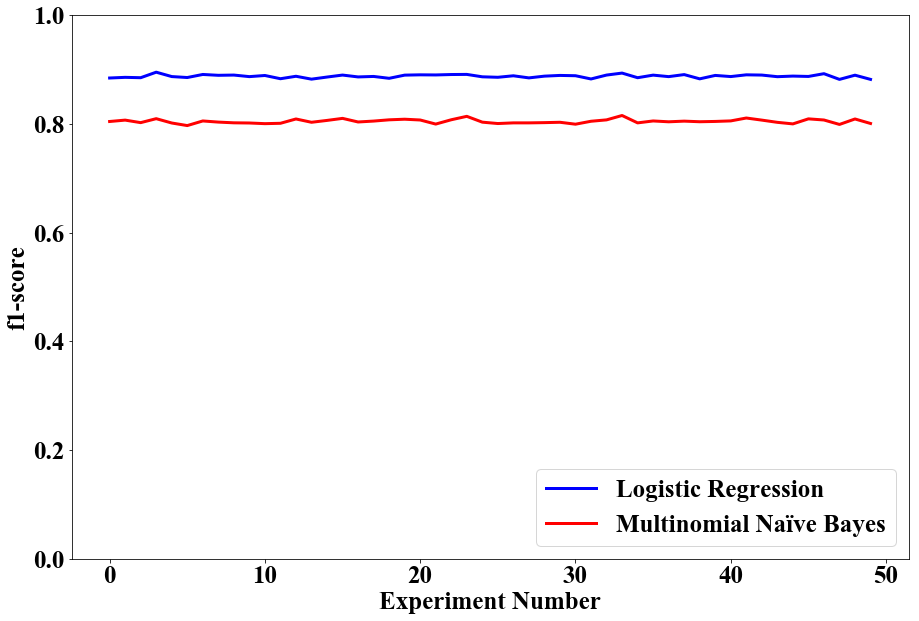

In [37]:
lw = 3

num_iter = [i for i in range(len(lr_f1_0))]

plt.figure(figsize=(15,10))
#plt.plot(num_iter, lr_f1_0, c='b', lw=lw, label='Logistic Regression')
#plt.plot(num_iter, mnb_f1_0, c='r', lw=lw, label='Multinomial Naïve Bayes')
plt.plot(num_iter, lr_f1, c='b', lw=lw, label='Logistic Regression')
plt.plot(num_iter, mnb_f1, c='r', lw=lw, label='Multinomial Naïve Bayes')
plt.ylim(0,1)
plt.ylabel('f1-score',fontsize=25)
plt.xlabel('Experiment Number',fontsize=25)
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.legend(loc="lower right",fontsize=25)
plt.savefig('f1score.png',bbox_inches='tight')
plt.show()

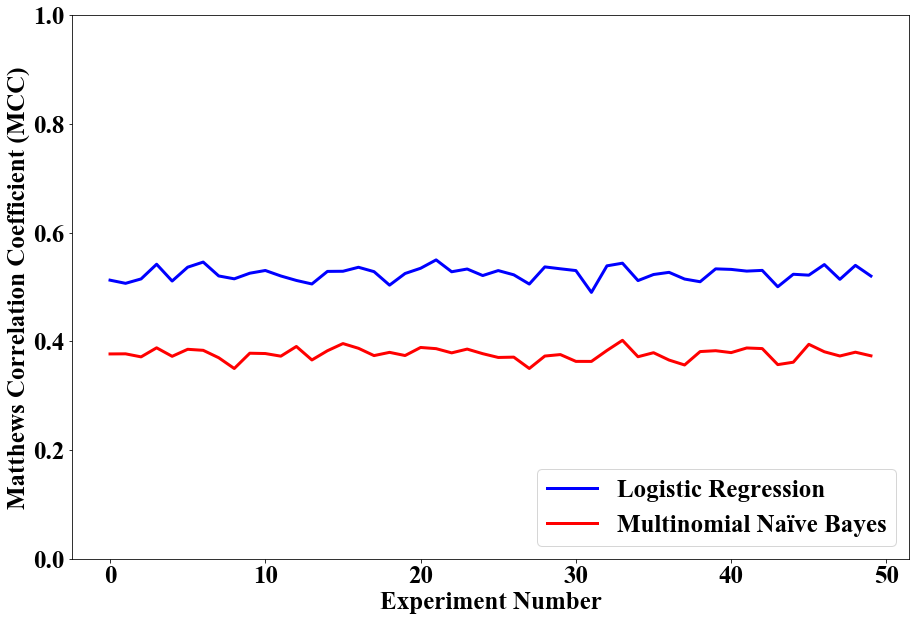

In [35]:
num_iter = [i for i in range(len(lr_f1_0))]

plt.figure(figsize=(15,10))
plt.plot(num_iter, lr_mcc, c='b', lw=lw, label='Logistic Regression')
plt.plot(num_iter, mnb_mcc, c='r', lw=lw, label='Multinomial Naïve Bayes')
plt.ylim(0,1)
plt.ylabel('Matthews Correlation Coefficient (MCC)',fontsize=25)
plt.xlabel('Experiment Number',fontsize=25)
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.legend(loc="lower right",fontsize=25)
plt.savefig('mcc.png',bbox_inches='tight')
plt.show()

## Step 13: Statistical Significance Test Using Wilcoxon Signed Rank Test

In [36]:
# Test the f1-score
kw = wilcoxon(mnb_f1, lr_f1)
print(kw)
print(bool(kw.pvalue < 0.05))

# Test the f1-score Minority
kw = wilcoxon(mnb_f1_0, lr_f1_0)
print(kw)
print(bool(kw.pvalue < 0.05))

# Test the MCC
kw = wilcoxon(mnb_mcc, lr_mcc)
print(kw)
print(bool(kw.pvalue < 0.05))

WilcoxonResult(statistic=0.0, pvalue=7.5518047582806747e-10)
True
WilcoxonResult(statistic=0.0, pvalue=7.5569294558635658e-10)
True
WilcoxonResult(statistic=0.0, pvalue=7.5569294558635658e-10)
True


## Step 14: Generate the ROC and Precision Recall Curve

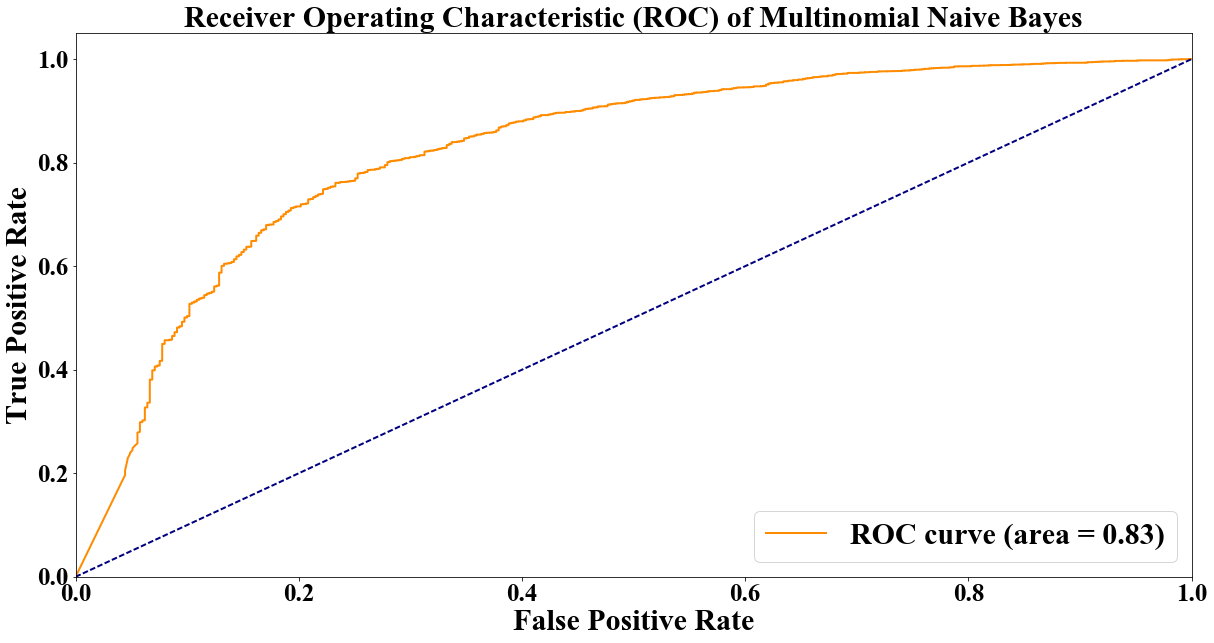

In [82]:
X = Xs_train
Y = Y_train

# Binarize the output
Y = label_binarize(Y, classes=[0, 1, 2])
Y = Y[:,:-1]
n_classes = Y.shape[1]

y_test = label_binarize(Y_test, classes=[0, 1, 2])
y_test = y_test[:,:-1]



# Learn to predict each class against the other
classifier = OneVsRestClassifier(MultinomialNB(alpha=0.01))
y_score = classifier.fit(X, Y).predict_proba(Xs_test)
y_predict = classifier.predict(Xs_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(20,10))

plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=30)
plt.ylabel('True Positive Rate',fontsize=30)
plt.title('Receiver Operating Characteristic (ROC) of Multinomial Naive Bayes', fontsize=30)
plt.legend(loc="lower right",fontsize=30)
plt.show()

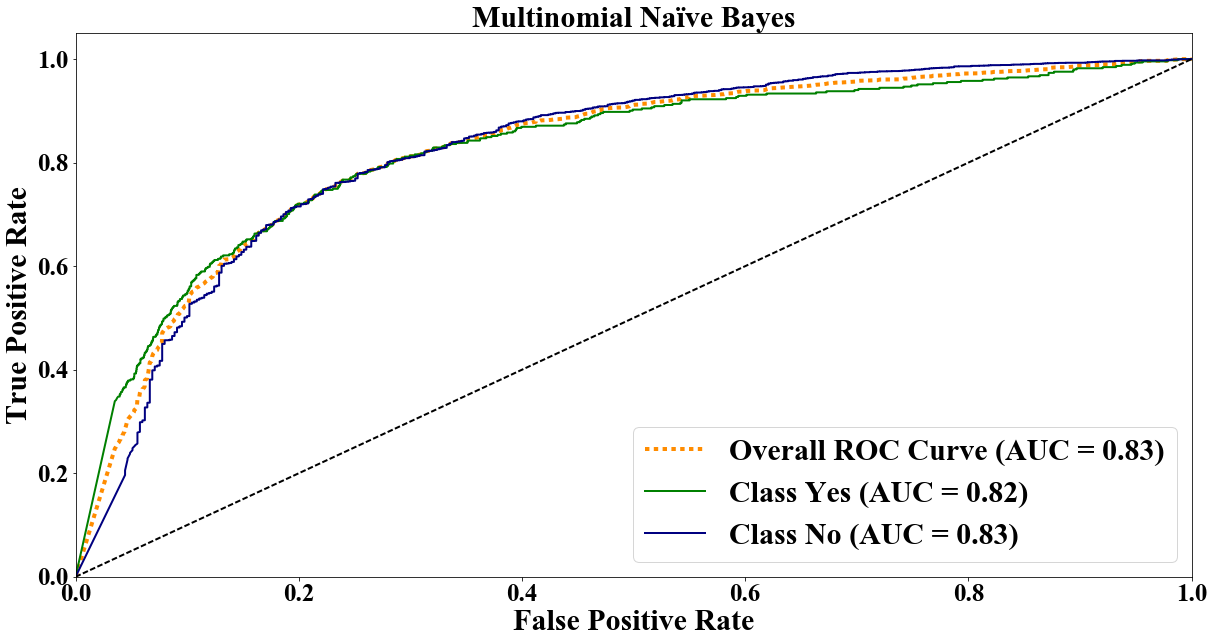

In [83]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,10))
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Overall ROC Curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='darkorange', linestyle=':', linewidth=4)

colors = cycle(['green', 'navy', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Class {0} (AUC = {1:0.2f})'
             ''.format(target_label[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=30)
plt.ylabel('True Positive Rate',fontsize=30)
plt.title('Multinomial Naïve Bayes', fontsize=30)
plt.legend(loc="lower right",fontsize=30)
plt.savefig('mnb_roc.png',bbox_inches='tight')
plt.show()

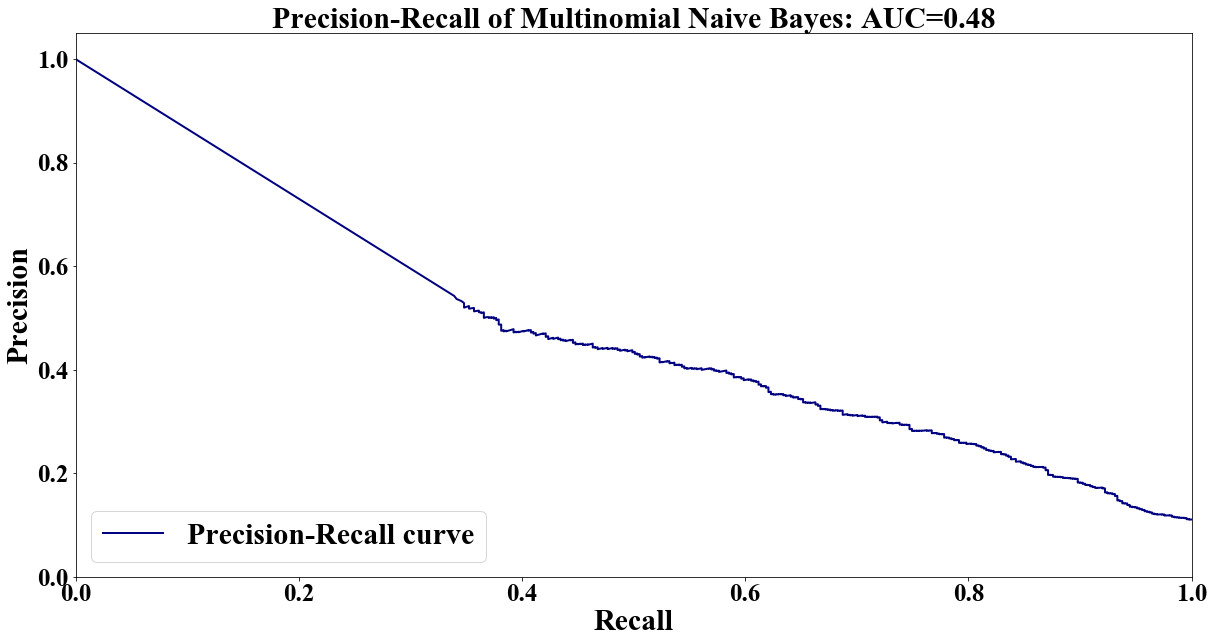

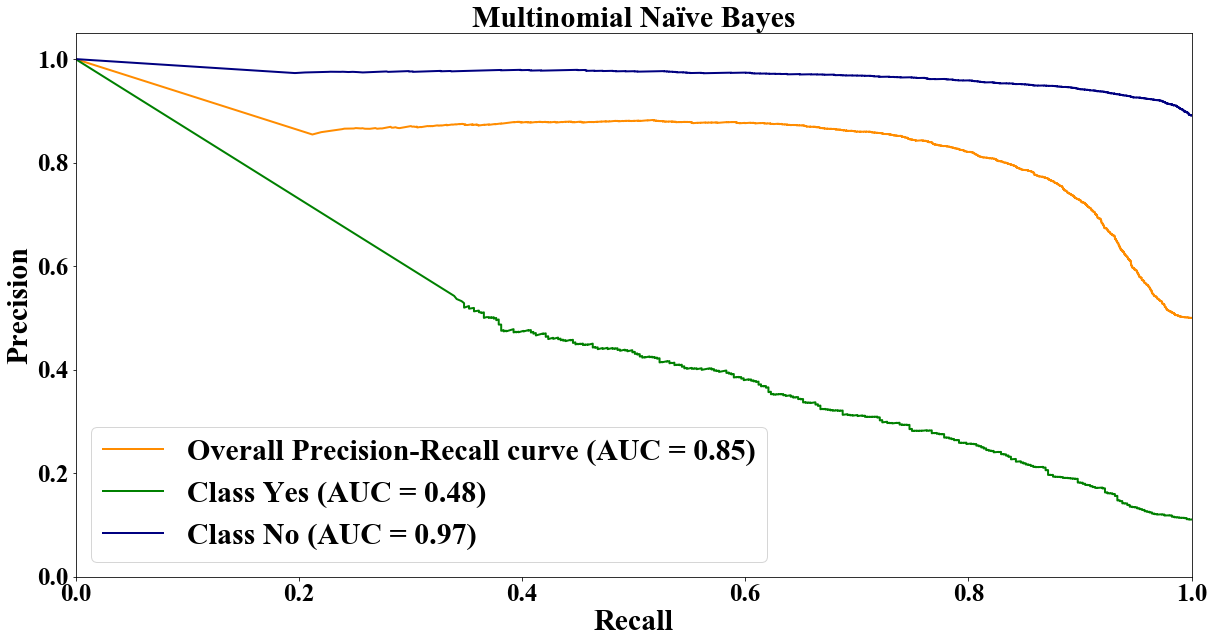

In [85]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(MultinomialNB(alpha=0.01))
y_score = classifier.fit(X, Y).predict_proba(Xs_test)

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")


# Plot Precision-Recall curve
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(recall[0], precision[0], lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall of Multinomial Naive Bayes: AUC={0:0.2f}'.format(average_precision[0]),fontsize=30)
plt.legend(loc="lower left",fontsize=30)
plt.show()

# Plot Precision-Recall curve for each class
colors = cycle(['green', 'navy', 'cornflowerblue'])
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(recall["micro"], precision["micro"], color='darkorange', lw=lw,
         label='Overall Precision-Recall curve (AUC = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='Class {0} (AUC = {1:0.2f})'
                   ''.format(target_label[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)
plt.title('Multinomial Naïve Bayes',fontsize=30)
plt.legend(loc="lower left",fontsize=30)
plt.savefig('mnb_pr.png',bbox_inches='tight')
plt.show()

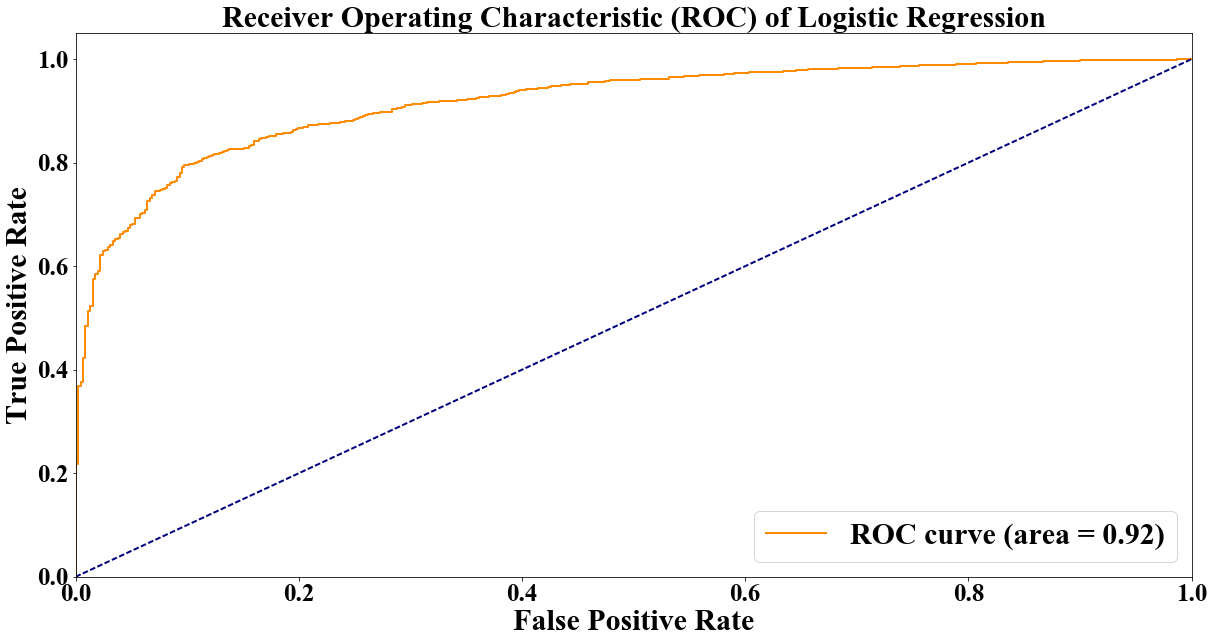

In [86]:
X = Xs_train
Y = Y_train

# Binarize the output
Y = label_binarize(Y, classes=[0, 1, 2])
Y = Y[:,:-1]
n_classes = Y.shape[1]

y_test = label_binarize(Y_test, classes=[0, 1, 2])
y_test = y_test[:,:-1]


# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(C=1, class_weight=None, max_iter=100, penalty='l2'))
y_score = classifier.fit(X, Y).decision_function(Xs_test)
y_predict = classifier.predict(Xs_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(20,10))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=30)
plt.ylabel('True Positive Rate',fontsize=30)
plt.title('Receiver Operating Characteristic (ROC) of Logistic Regression', fontsize=30)
plt.legend(loc="lower right",fontsize=30)
plt.show()

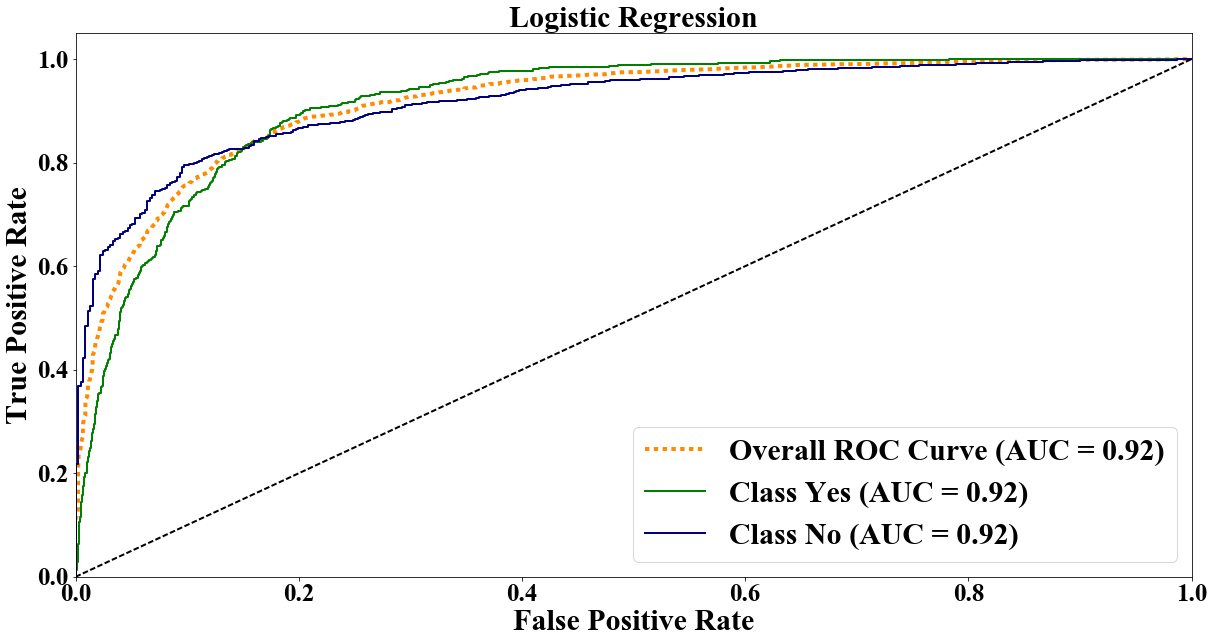

In [87]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,10))
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Overall ROC Curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='darkorange', linestyle=':', linewidth=4)

colors = cycle(['green', 'navy', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Class {0} (AUC = {1:0.2f})'
             ''.format(target_label[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=30)
plt.ylabel('True Positive Rate',fontsize=30)
plt.title('Logistic Regression', fontsize=30)
plt.legend(loc="lower right",fontsize=30)
plt.savefig('lr_roc.png',bbox_inches='tight')
plt.show()

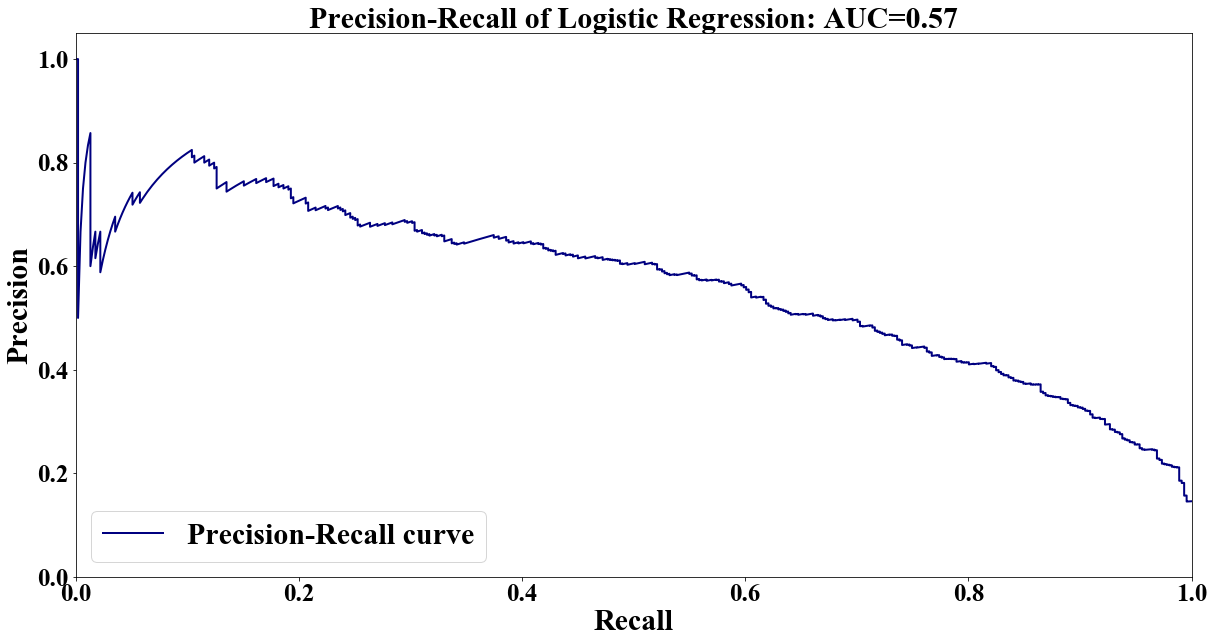

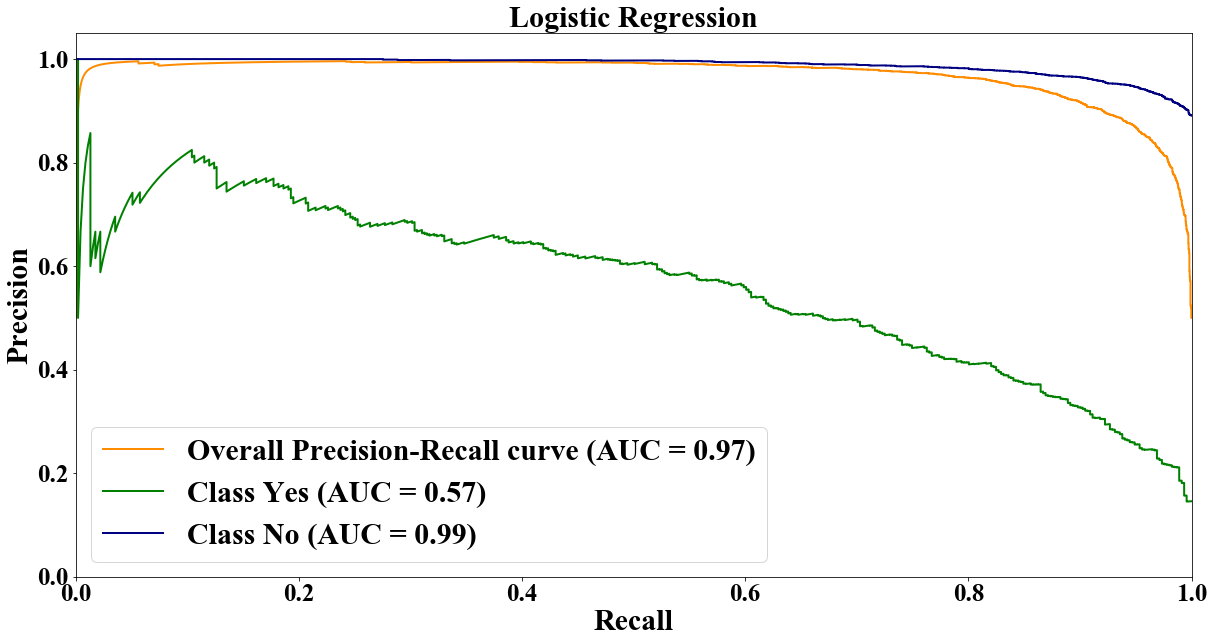

In [88]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(C= 100.0, class_weight = None, max_iter = 10, penalty = 'l1'))
y_score = classifier.fit(X, Y).decision_function(Xs_test)

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")


# Plot Precision-Recall curve
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(recall[0], precision[0], lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall of Logistic Regression: AUC={0:0.2f}'.format(average_precision[0]),fontsize=30)
plt.legend(loc="lower left",fontsize=30)
plt.show()

# Plot Precision-Recall curve for each class
colors = cycle(['green', 'navy', 'cornflowerblue'])
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(recall["micro"], precision["micro"], color='darkorange', lw=lw,
         label='Overall Precision-Recall curve (AUC = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='Class {0} (AUC = {1:0.2f})'
                   ''.format(target_label[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)
plt.title('Logistic Regression',fontsize=30)
plt.legend(loc="lower left",fontsize=30)
plt.savefig('lr_pr.png',bbox_inches='tight')
plt.show()